# Import des librairies

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2
import re

from sklearn import neighbors, svm, model_selection, preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

# Fonctions utiles

In [3]:
# Chargement des données silver

df_friches_silver = pd.read_csv("friches_silver.csv", sep=",", low_memory=False, index_col=0)

print("Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :")
print(f"{df_friches_silver.shape[0]} friches chargées — {df_friches_silver.shape[1]} variables")
print("Pas de doublon detectés")

display(df_friches_silver.head(5))

Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :
2331 friches chargées — 75 variables
Pas de doublon detectés


,site_securite,site_reconv_type,bati_nombre,bati_pollution,bati_etat,proprio_personne,sol_pollution_existe,unite_fonciere_surface,longitude,latitude,...,site_type_friche_militaire,site_type_friche_portuaire,site_type_mixte,site_actu_annee,site_identif_annee,actualisation_jour,site_actu_mois_sin,site_actu_mois_cos,site_actu_jour_sin,site_actu_jour_cos
17,0,0,2,0,0,0,0,42877,1.337672,43.60932,...,0,0,0,2024,1997,9540,0.866025,5.000000e-01,0.485302,-0.874347
20,0,0,2,0,1,1,0,143,-0.530774,49.29225,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
25,0,1,0,0,0,1,0,28389,-0.546245,49.28301,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
35,0,2,3,0,1,1,0,2619,-0.532152,49.29449,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
45,0,1,0,0,0,1,0,60709,-0.619462,49.20100,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347


In [4]:
dict_reconv = {
 "habitat": 0,
 "renaturation": 1,
 "équipement public": 2,
 "mixte": 3,
 "autres activités économiques": 4,
 "aménagement d'espace public": 5,
 "commerce": 6,
 "panneaux photovoltaiques": 7,
 "Energie, hors photovoltaique": 8,
 "bureau": 9,
 "industrie": 10}

# Random Forest sans habitat

Nettoyage des classes Habitats et les classes minoritaires, la classe 8 avec 1 exemple doit être obligatoirement enlevé.
Problématique: pourquoi habitat est majoritaire? Dans quels cas habitat apparaît t-il le plus?

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Étape 1 : Séparer X et y
X = df_friches_silver.drop(columns='site_reconv_type')
y = df_friches_silver['site_reconv_type']

# Étape 2 : Fusion/suppression de classes rares
y = y.replace({ 5: -1, 0: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]



# Étape 3 : Nettoyage éventuel des colonnes non numériques (au cas où)
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# Étape 5 : Entraînement du modèle Random Forest avec hyperparamètres manuels
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

Accuracy : 0.5613207547169812

Classification Report :
               precision    recall  f1-score   support

           1       0.57      0.29      0.38        14
           2       0.54      0.30      0.39        43
           3       0.52      0.57      0.54        70
           4       0.58      0.80      0.68        66
           6       0.69      0.47      0.56        19

    accuracy                           0.56       212
   macro avg       0.58      0.49      0.51       212
weighted avg       0.56      0.56      0.54       212



## Random Forest avec Habitat et équilibrage class_weight='balanced'

Accuracy : 0.5471698113207547

Classification Report :
               precision    recall  f1-score   support

           1       0.40      0.43      0.41        14
           2       0.52      0.37      0.43        43
           3       0.60      0.49      0.54        70
           4       0.60      0.76      0.67        66
           6       0.38      0.53      0.44        19

    accuracy                           0.55       212
   macro avg       0.50      0.51      0.50       212
weighted avg       0.55      0.55      0.54       212



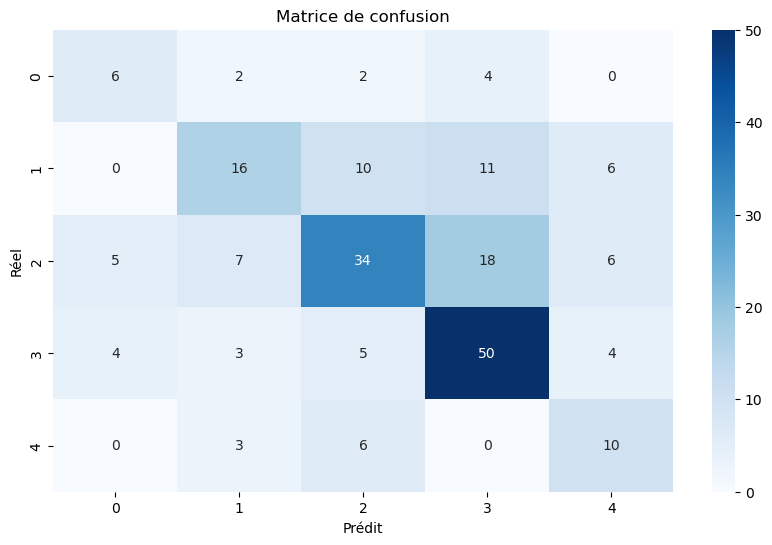

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Chargement du DataFrame propre
# (Assure-toi que df_friches_silver est bien chargé)

# Étape 2 : Nettoyage (suppression des classes trop rares ou douteuses)
y = df_friches_silver['site_reconv_type']
X = df_friches_silver.drop(columns='site_reconv_type')

y = y.replace({ 5: -1, 0: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]

# Étape 3 : Nettoyage des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Étape 5 : Modèle avec pondération automatique
clf = RandomForestClassifier(
    n_estimators=400, #besoin de plus estimator ici
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',  # clé ici
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Étape 7 : Visualisation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


La classe Mixte est bien discriminée en l'absence d'habitat

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
from tqdm import tqdm
import numpy as np

# Définir grille
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 20, 30]
}

# Création des combinaisons de paramètres
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['min_samples_split'],
    param_grid['max_depth']
))

best_score = -np.inf
best_params = None

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for n_est, min_split, max_d in tqdm(param_combinations, desc="Grid search en cours"):
    clf = RandomForestClassifier(
        n_estimators=n_est,
        min_samples_split=min_split,
        max_depth=max_d,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )

    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))

    mean_score = np.mean(f1_scores)

    if mean_score > best_score:
        best_score = mean_score
        best_params = {
            'n_estimators': n_est,
            'min_samples_split': min_split,
            'max_depth': max_d
        }

print("\n✅ Meilleurs paramètres trouvés :", best_params)
print("🏆 Score f1_macro moyen :", round(best_score, 4))


Grid search en cours: 100%|██████████| 27/27 [01:14<00:00,  2.75s/it]


✅ Meilleurs paramètres trouvés : {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 30}
🏆 Score f1_macro moyen : 0.465


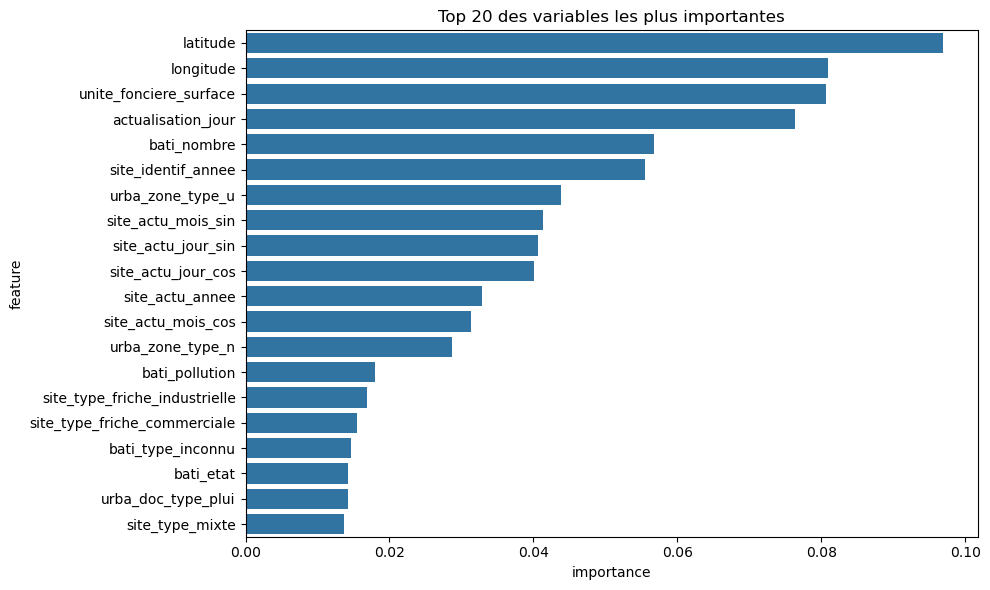

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importance des features
importances = clf.feature_importances_
feature_names = X_train.columns

# Création d’un DataFrame trié
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Affichage graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20))
plt.title("Top 20 des variables les plus importantes")
plt.tight_layout()
plt.show()


In [9]:
# Extraction des 10 plus importantes (à adapter si tu veux changer de seuil)
top_features = feat_imp_df['feature'].head(10).tolist()

X_reduit = X[top_features]


## Random forest avec les features les plus importantes

✅ Accuracy: 0.3680555555555556

📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      0.39      0.54       220
           1       0.28      0.57      0.37        14
           2       0.20      0.30      0.24        43
           3       0.17      0.19      0.18        70
           4       0.29      0.44      0.35        66
           6       0.16      0.58      0.25        19

    accuracy                           0.37       432
   macro avg       0.33      0.41      0.32       432
weighted avg       0.56      0.37      0.40       432



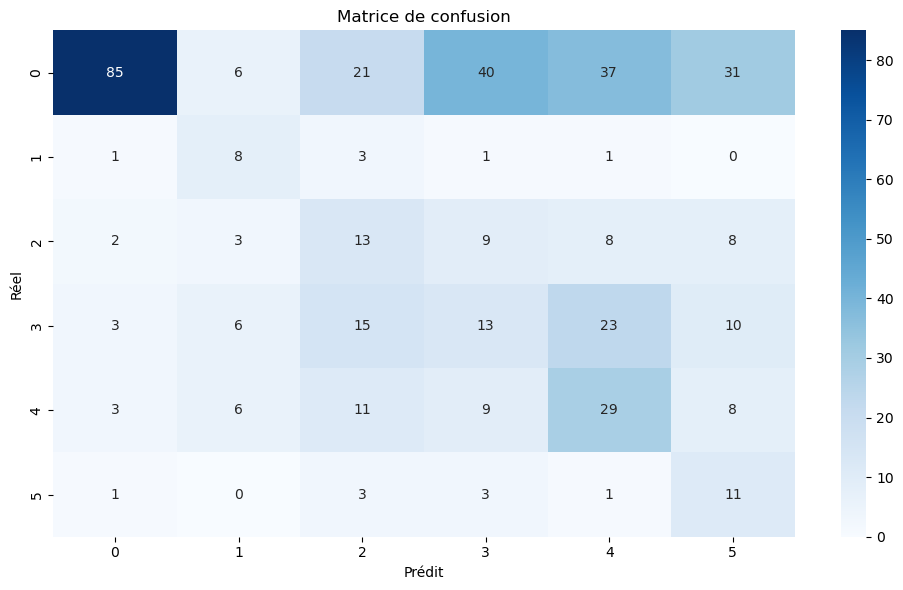

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Étape 1 : Liste des top features d’après importance (visuel fourni)
top_features = [
    'site_securite', 'bati_pollution', 'bati_etat', 'bati_vacance_occupe',
    'bati_vacance_partiellement_occupe', 'bati_vacance_vacant',
    'sol_pollution_existe', 'site_type_friche_industrielle', 'site_type_friche_d_habitat',
    'site_type_mixte', 'urba_zone_type_u', 'urba_doc_type_plui'
]


# Étape 2 : Définition X / y
X = df_friches_silver[top_features].copy()
y = df_friches_silver['site_reconv_type'].copy()

# Étape 3 : Suppression des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

y = y.replace({ 5: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Étape 5 : Modèle
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=20,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Prédiction et évaluation
y_pred = clf.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Rapport de classification :")
print(classification_report(y_test, y_pred))

# Étape 7 : Matrice de confusion
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()


classe 3 confindue avec la 4

## Screening d'autre modèles

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# === Données ===
X = df_friches_silver.drop(columns='site_reconv_type')
y = df_friches_silver['site_reconv_type']

# Filtrage des classes "moches"
y = y.replace({5: -1, 0: -1, 8: -1, 7: -1, 9: -1, 10: -1})
mask = y != -1
X = X[mask]
y = y[mask]

# Suppression des colonnes non numériques
X = X.select_dtypes(include=np.number)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33, random_state=42
)

# Dictionnaire des modèles
models = {
    "LogisticRegression": lambda: make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "RandomForest": lambda: RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": lambda: make_pipeline(StandardScaler(), SVC()),
    "XGBoost": lambda: XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "NaiveBayes": lambda: GaussianNB(),
    "KNN": lambda: make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "DecisionTree": lambda: DecisionTreeClassifier(random_state=42),
}

# Exécution des modèles
results = {}

for name, model_fn in tqdm(models.items(), desc="Entraînement des modèles"):
    try:
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        results[name] = {"accuracy": acc, "f1_weighted": f1}
        print(f"\n{name}\n", classification_report(y_test, y_pred, zero_division=0))
    except Exception as e:
        print(f"Erreur avec {name} : {e}")

# Affichage résumé
print("\nRésultats comparatifs :")
for name, scores in results.items():
    print(f"{name} - Accuracy: {scores['accuracy']:.2f}, F1 (pondéré): {scores['f1_weighted']:.2f}")

Entraînement des modèles:  14%|█▍        | 1/7 [00:00<00:00,  6.37it/s]


LogisticRegression
               precision    recall  f1-score   support

           1       0.39      0.30      0.34        23
           2       0.44      0.31      0.36        71
           3       0.47      0.47      0.47       116
           4       0.56      0.72      0.63       109
           6       0.58      0.45      0.51        31

    accuracy                           0.51       350
   macro avg       0.49      0.45      0.46       350
weighted avg       0.50      0.51      0.49       350



Entraînement des modèles: 100%|██████████| 7/7 [00:00<00:00,  9.99it/s]


RandomForest
               precision    recall  f1-score   support

           1       0.53      0.35      0.42        23
           2       0.46      0.31      0.37        71
           3       0.46      0.52      0.49       116
           4       0.55      0.68      0.61       109
           6       0.64      0.45      0.53        31

    accuracy                           0.51       350
   macro avg       0.53      0.46      0.48       350
weighted avg       0.51      0.51      0.50       350


SVM
               precision    recall  f1-score   support

           1       0.46      0.26      0.33        23
           2       0.29      0.10      0.15        71
           3       0.43      0.47      0.45       116
           4       0.51      0.78      0.61       109
           6       0.75      0.39      0.51        31

    accuracy                           0.47       350
   macro avg       0.49      0.40      0.41       350
weighted avg       0.45      0.47      0.44       350

E

In [12]:
df_friches_silver.columns

Index(['site_securite', 'site_reconv_type', 'bati_nombre', 'bati_pollution',
       'bati_etat', 'proprio_personne', 'sol_pollution_existe',
       'unite_fonciere_surface', 'longitude', 'latitude',
       'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_autres',
       'uzf_equipements_public', 'uzf_espace_naturel',
       'uzf_espace_remarquable', 'uzf_habitat', 'uzf_loisirs_et_tourisme',
       'uzf_mixte_habitat_activite',
       'uzf_sans_objet_ou_non_encore_definie_dans_le_reglement',
       'so_friche_agro_industrielle', 'so_friche_carriere_ou_mine',
       'so_friche_commerciale', 'so_friche_cultuelle', 'so_friche_d_habitat',
       'so_friche_d_equipement_public', 'so_friche_hospitaliere',
       'so_friche_industrielle', 'so_friche_logistique',
       'so_friche_loisir_tourisme_hotellerie', 'so_friche_non_occupee',
       'so_mixte', 'bati_type_commercial', 'bati_type_inconnu',
       'bati_type_industriel', 'bati_type_residentiel',
       'bati_type_secteur_tertiaire

## Selection des features RFCV/LASSO/SelectKBest

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring='f1_weighted', n_jobs=-1)
selector.fit(X, y)

# Résultat :
X_selected = X.loc[:, selector.support_]
print("Variables sélectionnées :", X_selected.columns.tolist())

Variables sélectionnées : ['site_securite', 'bati_nombre', 'bati_pollution', 'bati_etat', 'proprio_personne', 'sol_pollution_existe', 'unite_fonciere_surface', 'longitude', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_autres', 'uzf_habitat', 'so_friche_commerciale', 'so_friche_non_occupee', 'bati_type_commercial', 'bati_type_inconnu', 'bati_vacance_vacant', 'urba_zone_type_auc', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_plu', 'urba_doc_type_plui', 'urba_doc_type_u', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_habitat', 'site_type_friche_d_equipement_public', 'site_type_friche_ferroviaire', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_type_friche_logistique', 'site_type_friche_loisir_tourisme_hotellerie', 'site_type_mixte', 'site_actu_annee', 'site_identif_annee', 'actualisation_jour', 'site_actu_mois_sin', 'site_actu_mois_cos', 'site_actu_jour_sin', 'site_

In [17]:
nunique = X.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
X = X.drop(columns=constant_cols)

In [18]:
selector = SelectKBest(score_func=f_classif, k=30)
X_kbest = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Variables sélectionnées :", selected_features)

Variables sélectionnées : ['site_securite', 'bati_pollution', 'bati_etat', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_habitat', 'so_friche_commerciale', 'so_friche_non_occupee', 'bati_type_commercial', 'bati_type_inconnu', 'bati_vacance_occupe', 'bati_vacance_vacant', 'urba_zone_type_a', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_cc', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_habitat', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_actu_annee', 'site_identif_annee', 'actualisation_jour', 'site_actu_mois_sin', 'site_actu_jour_sin', 'site_actu_jour_cos']


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

model = LogisticRegression(penalty='l1', solver='liblinear')
sfm = SelectFromModel(model)
X_l1 = sfm.fit_transform(X, y)


In [19]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Standardisation + LassoCV dans un pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=42, n_jobs=-1)
)

# Fit du pipeline
pipeline.fit(X, y)

# Récupération des coefficients
lasso = pipeline.named_steps['lassocv']
coefs = lasso.coef_

# Sélection des variables non-nulles
selected_features = X.columns[np.abs(coefs) > 1e-5].tolist()

print(f"Variables sélectionnées ({len(selected_features)} sur {X.shape[1]}) :")
print(selected_features)


Variables sélectionnées (35 sur 69) :
['bati_pollution', 'bati_etat', 'sol_pollution_existe', 'longitude', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_espace_naturel', 'uzf_espace_remarquable', 'uzf_sans_objet_ou_non_encore_definie_dans_le_reglement', 'so_friche_agro_industrielle', 'so_friche_carriere_ou_mine', 'so_friche_hospitaliere', 'so_friche_logistique', 'so_friche_loisir_tourisme_hotellerie', 'bati_type_commercial', 'bati_type_inconnu', 'bati_type_secteur_tertiaire', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_plui', 'urba_doc_type_psmv', 'urba_doc_type_u', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_type_friche_logistique', 'site_type_friche_militaire', 'site_type_mixte', 'site_actu_annee', 'actualisation_jour', 'site_actu_mois_cos']


C:\Users\rovar\anaconda3\envs\cartofriche\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.401685517847568, tolerance: 0.10861770956316415
  model = cd_fast.enet_coordinate_descent_gram(


In [21]:
# Supposons que tu as ces 3 listes
features_rfecv = ['site_securite', 'bati_nombre', 'bati_pollution', 'bati_etat', 'proprio_personne', 'sol_pollution_existe', 'unite_fonciere_surface', 'longitude', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_autres', 'uzf_habitat', 'so_friche_commerciale', 'so_friche_non_occupee', 'bati_type_commercial', 'bati_type_inconnu', 'bati_vacance_vacant', 'urba_zone_type_auc', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_plu', 'urba_doc_type_plui', 'urba_doc_type_u', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_habitat', 'site_type_friche_d_equipement_public', 'site_type_friche_ferroviaire', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_type_friche_logistique', 'site_type_friche_loisir_tourisme_hotellerie', 'site_type_mixte', 'site_actu_annee', 'site_identif_annee', 'actualisation_jour', 'site_actu_mois_sin', 'site_actu_mois_cos', 'site_actu_jour_sin', 'site_actu_jour_cos']      # 41 variables du RFECV
features_kbest = ['site_securite', 'bati_pollution', 'bati_etat', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_habitat', 'so_friche_commerciale', 'so_friche_non_occupee', 'bati_type_commercial', 'bati_type_inconnu', 'bati_vacance_occupe', 'bati_vacance_vacant', 'urba_zone_type_a', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_cc', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_habitat', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_actu_annee', 'site_identif_annee', 'actualisation_jour', 'site_actu_mois_sin', 'site_actu_jour_sin', 'site_actu_jour_cos']     # 30 variables du SelectKBest
features_lasso = ['bati_pollution', 'bati_etat', 'sol_pollution_existe', 'longitude', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_espace_naturel', 'uzf_espace_remarquable', 'uzf_sans_objet_ou_non_encore_definie_dans_le_reglement', 'so_friche_agro_industrielle', 'so_friche_carriere_ou_mine', 'so_friche_hospitaliere', 'so_friche_logistique', 'so_friche_loisir_tourisme_hotellerie', 'bati_type_commercial', 'bati_type_inconnu', 'bati_type_secteur_tertiaire', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_plui', 'urba_doc_type_psmv', 'urba_doc_type_u', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_type_friche_logistique', 'site_type_friche_militaire', 'site_type_mixte', 'site_actu_annee', 'actualisation_jour', 'site_actu_mois_cos']      # 35 variables du Lasso

# Conversion en sets pour croisement
rfecv_set = set(features_rfecv)
kbest_set = set(features_kbest)
lasso_set = set(features_lasso)

# Variables communes aux 3 méthodes
intersection_3 = rfecv_set & kbest_set & lasso_set

# Variables communes à au moins 2 méthodes
intersection_2 = (rfecv_set & kbest_set) | (rfecv_set & lasso_set) | (kbest_set & lasso_set)

# Variables sélectionnées par au moins 1 méthode
union_all = rfecv_set | kbest_set | lasso_set

# Variables sélectionnées par une seule méthode
exclusive_rfecv = rfecv_set - (kbest_set | lasso_set)
exclusive_kbest = kbest_set - (rfecv_set | lasso_set)
exclusive_lasso = lasso_set - (rfecv_set | kbest_set)

# Résumé
print("🟩 Communes aux 3 méthodes :", sorted(intersection_3))
print("\n🟨 Communes à au moins 2 méthodes :", sorted(intersection_2))
print("\n🟥 Sélectionnées uniquement par RFECV :", sorted(exclusive_rfecv))
print("🟥 Sélectionnées uniquement par KBest :", sorted(exclusive_kbest))
print("🟥 Sélectionnées uniquement par Lasso :", sorted(exclusive_lasso))


🟩 Communes aux 3 méthodes : ['actualisation_jour', 'bati_etat', 'bati_pollution', 'bati_type_commercial', 'bati_type_inconnu', 'latitude', 'site_actu_annee', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'uzf_activite_agricole', 'uzf_activite_economique']

🟨 Communes à au moins 2 méthodes : ['actualisation_jour', 'bati_etat', 'bati_pollution', 'bati_type_commercial', 'bati_type_inconnu', 'bati_vacance_vacant', 'latitude', 'longitude', 'site_actu_annee', 'site_actu_jour_cos', 'site_actu_jour_sin', 'site_actu_mois_cos', 'site_actu_mois_sin', 'site_identif_annee', 'site_securite', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_d_habitat', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_type_friche

In [27]:
#Test avec les 35 variables 🟨
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# === Préparation des données ===
X = df_friches_silver.drop(columns='site_reconv_type')
y = df_friches_silver['site_reconv_type']

# Filtrage des classes peu représentées ou non pertinentes
y = y.replace({5: -1, 0: -1, 8: -1, 7: -1, 9: -1, 10: -1})
mask = y != -1
X = X[mask]
y = y[mask]

# Ne garder que les colonnes numériques
X = X[['bati_pollution', 'bati_etat', 'sol_pollution_existe', 'longitude', 'latitude', 'uzf_activite_agricole', 'uzf_activite_economique', 'uzf_espace_naturel', 'uzf_espace_remarquable', 'uzf_sans_objet_ou_non_encore_definie_dans_le_reglement', 'so_friche_agro_industrielle', 'so_friche_carriere_ou_mine', 'so_friche_hospitaliere', 'so_friche_logistique', 'so_friche_loisir_tourisme_hotellerie', 'bati_type_commercial', 'bati_type_inconnu', 'bati_type_secteur_tertiaire', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'urba_doc_type_plui', 'urba_doc_type_psmv', 'urba_doc_type_u', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'site_type_friche_logistique', 'site_type_friche_militaire', 'site_type_mixte', 'site_actu_annee', 'actualisation_jour', 'site_actu_mois_cos']]


# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Modèles à tester ===
models = {
    "LogisticRegression": lambda: make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "RandomForest": lambda: RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": lambda: make_pipeline(StandardScaler(), SVC()),
    "NaiveBayes": lambda: GaussianNB(),
    "KNN": lambda: make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "DecisionTree": lambda: DecisionTreeClassifier(random_state=42),
}

# === Entraînement et évaluation ===
results = {}

for name, model_fn in tqdm(models.items(), desc="Entraînement des modèles"):
    try:
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        results[name] = {"accuracy": acc, "f1_weighted": f1}
        print(f"\n{name}\n", classification_report(y_test, y_pred, zero_division=0))
    except Exception as e:
        print(f"❌ Erreur avec {name} : {e}")

# === Résumé final ===
print("\n📊 Résultats comparatifs :")
for name, scores in results.items():
    print(f"{name:<20} - Accuracy: {scores['accuracy']:.2f} | F1 (pondéré): {scores['f1_weighted']:.2f}")


Entraînement des modèles:  17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]


LogisticRegression
               precision    recall  f1-score   support

           1       0.44      0.29      0.35        14
           2       0.30      0.14      0.19        43
           3       0.44      0.49      0.46        70
           4       0.52      0.71      0.60        66
           6       0.60      0.47      0.53        19

    accuracy                           0.47       212
   macro avg       0.46      0.42      0.43       212
weighted avg       0.45      0.47      0.45       212



Entraînement des modèles:  50%|█████     | 3/6 [00:00<00:00,  4.29it/s]


RandomForest
               precision    recall  f1-score   support

           1       0.56      0.36      0.43        14
           2       0.42      0.23      0.30        43
           3       0.44      0.56      0.49        70
           4       0.62      0.68      0.65        66
           6       0.56      0.53      0.54        19

    accuracy                           0.51       212
   macro avg       0.52      0.47      0.48       212
weighted avg       0.51      0.51      0.50       212


SVM
               precision    recall  f1-score   support

           1       0.17      0.14      0.15        14
           2       0.14      0.05      0.07        43
           3       0.41      0.53      0.46        70
           4       0.55      0.70      0.62        66
           6       0.75      0.47      0.58        19

    accuracy                           0.45       212
   macro avg       0.40      0.38      0.38       212
weighted avg       0.41      0.45      0.42       212




Entraînement des modèles: 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


KNN
               precision    recall  f1-score   support

           1       0.10      0.07      0.08        14
           2       0.29      0.33      0.31        43
           3       0.43      0.50      0.46        70
           4       0.62      0.55      0.58        66
           6       0.60      0.47      0.53        19

    accuracy                           0.45       212
   macro avg       0.41      0.38      0.39       212
weighted avg       0.46      0.45      0.45       212


DecisionTree
               precision    recall  f1-score   support

           1       0.43      0.43      0.43        14
           2       0.40      0.33      0.36        43
           3       0.51      0.57      0.54        70
           4       0.59      0.56      0.57        66
           6       0.50      0.58      0.54        19

    accuracy                           0.51       212
   macro avg       0.49      0.49      0.49       212
weighted avg       0.51      0.51      0.51       212




In [26]:
#Tests avec les 17 variables 🟩
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# === Préparation des données ===
X = df_friches_silver.drop(columns='site_reconv_type')
y = df_friches_silver['site_reconv_type']

# Filtrage des classes peu représentées ou non pertinentes
y = y.replace({5: -1, 0: -1, 8: -1, 7: -1, 9: -1, 10: -1})
mask = y != -1
X = X[mask]
y = y[mask]

# Ne garder que les colonnes numériques
X = X[['actualisation_jour', 'bati_etat', 'bati_pollution', 'bati_type_commercial', 'bati_type_inconnu', 'latitude', 'site_actu_annee', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'uzf_activite_agricole', 'uzf_activite_economique']]


# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Modèles à tester ===
models = {
    "LogisticRegression": lambda: make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "RandomForest": lambda: RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": lambda: make_pipeline(StandardScaler(), SVC()),
    "NaiveBayes": lambda: GaussianNB(),
    "KNN": lambda: make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "DecisionTree": lambda: DecisionTreeClassifier(random_state=42),
}

# === Entraînement et évaluation ===
results = {}

for name, model_fn in tqdm(models.items(), desc="Entraînement des modèles"):
    try:
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        results[name] = {"accuracy": acc, "f1_weighted": f1}
        print(f"\n{name}\n", classification_report(y_test, y_pred, zero_division=0))
    except Exception as e:
        print(f"❌ Erreur avec {name} : {e}")

# === Résumé final ===
print("\n📊 Résultats comparatifs :")
for name, scores in results.items():
    print(f"{name:<20} - Accuracy: {scores['accuracy']:.2f} | F1 (pondéré): {scores['f1_weighted']:.2f}")


Entraînement des modèles:  17%|█▋        | 1/6 [00:00<00:01,  4.44it/s]


LogisticRegression
               precision    recall  f1-score   support

           1       0.31      0.29      0.30        14
           2       0.31      0.12      0.17        43
           3       0.43      0.63      0.51        70
           4       0.60      0.59      0.60        66
           6       0.56      0.47      0.51        19

    accuracy                           0.48       212
   macro avg       0.44      0.42      0.42       212
weighted avg       0.46      0.48      0.45       212



Entraînement des modèles:  50%|█████     | 3/6 [00:01<00:00,  3.07it/s]


RandomForest
               precision    recall  f1-score   support

           1       0.30      0.43      0.35        14
           2       0.36      0.21      0.26        43
           3       0.41      0.50      0.45        70
           4       0.60      0.58      0.59        66
           6       0.56      0.53      0.54        19

    accuracy                           0.46       212
   macro avg       0.45      0.45      0.44       212
weighted avg       0.46      0.46      0.46       212


SVM
               precision    recall  f1-score   support

           1       0.33      0.29      0.31        14
           2       0.17      0.05      0.07        43
           3       0.39      0.53      0.45        70
           4       0.55      0.64      0.59        66
           6       0.56      0.47      0.51        19

    accuracy                           0.44       212
   macro avg       0.40      0.39      0.39       212
weighted avg       0.41      0.44      0.41       212




Entraînement des modèles: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]



KNN
               precision    recall  f1-score   support

           1       0.21      0.21      0.21        14
           2       0.32      0.28      0.30        43
           3       0.41      0.46      0.43        70
           4       0.50      0.47      0.48        66
           6       0.43      0.47      0.45        19

    accuracy                           0.41       212
   macro avg       0.38      0.38      0.38       212
weighted avg       0.41      0.41      0.41       212


DecisionTree
               precision    recall  f1-score   support

           1       0.33      0.50      0.40        14
           2       0.31      0.26      0.28        43
           3       0.41      0.44      0.43        70
           4       0.61      0.56      0.58        66
           6       0.55      0.58      0.56        19

    accuracy                           0.46       212
   macro avg       0.44      0.47      0.45       212
weighted avg       0.46      0.46      0.46       212




In [29]:
# Score de vétusté dangereuse
df_friches_silver['score_vetuste_pollution'] = df_friches_silver['bati_pollution'] * df_friches_silver['bati_etat']

# Score de densité bâtie
df_friches_silver['score_densite_batie'] = df_friches_silver['bati_nombre'] / (df_friches_silver['unite_fonciere_surface'] + 1)

# Score de pollution globale (sol + bâtiment)
df_friches_silver['score_pollution_globale'] = df_friches_silver['bati_pollution'] + df_friches_silver['sol_pollution_existe'].fillna(0)

# Score d’usage mixte
uzf_cols = [col for col in df_friches_silver.columns if col.startswith('uzf_')]
df_friches_silver['score_usage_mixte'] = df_friches_silver[uzf_cols].sum(axis=1)

# Score d’urbanisme favorable
zone_fav = df_friches_silver[['urba_zone_type_u', 'urba_zone_type_n', 'urba_zone_type_znc']].fillna(0)
doc_fav = df_friches_silver[['urba_doc_type_plui', 'urba_doc_type_u']].fillna(0)
df_friches_silver['score_urbanisme'] = zone_fav.sum(axis=1) + doc_fav.sum(axis=1)

# Binning temporel (très simple)
df_friches_silver['periode_identif'] = pd.cut(df_friches_silver['site_identif_annee'], bins=[1900, 2000, 2010, 2025], labels=['<2000', '2000-2010', '>2010'])
df_friches_silver = pd.get_dummies(df_friches_silver, columns=['periode_identif'], drop_first=True)


In [30]:
#Tests avec les 17 variables 🟩
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# === Préparation des données ===
X = df_friches_silver.drop(columns='site_reconv_type')
y = df_friches_silver['site_reconv_type']

# Filtrage des classes peu représentées ou non pertinentes
y = y.replace({5: -1, 0: -1, 8: -1, 7: -1, 9: -1, 10: -1})
mask = y != -1
X = X[mask]
y = y[mask]

# Ne garder que les colonnes numériques
X = X[['actualisation_jour', 'bati_etat', 'bati_pollution', 'bati_type_commercial', 'bati_type_inconnu', 'latitude', 'site_actu_annee', 'site_type_friche_agro_industrielle', 'site_type_friche_commerciale', 'site_type_friche_d_equipement_public', 'site_type_friche_hospitaliere', 'site_type_friche_industrielle', 'urba_zone_type_n', 'urba_zone_type_u', 'urba_zone_type_znc', 'uzf_activite_agricole', 'uzf_activite_economique']]


# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Modèles à tester ===
models = {
    "LogisticRegression": lambda: make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "RandomForest": lambda: RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": lambda: make_pipeline(StandardScaler(), SVC()),
    "NaiveBayes": lambda: GaussianNB(),
    "KNN": lambda: make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "DecisionTree": lambda: DecisionTreeClassifier(random_state=42),
}

# === Entraînement et évaluation ===
results = {}

for name, model_fn in tqdm(models.items(), desc="Entraînement des modèles"):
    try:
        model = model_fn()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
        results[name] = {"accuracy": acc, "f1_weighted": f1}
        print(f"\n{name}\n", classification_report(y_test, y_pred, zero_division=0))
    except Exception as e:
        print(f"❌ Erreur avec {name} : {e}")

# === Résumé final ===
print("\n📊 Résultats comparatifs :")
for name, scores in results.items():
    print(f"{name:<20} - Accuracy: {scores['accuracy']:.2f} | F1 (pondéré): {scores['f1_weighted']:.2f}")


Entraînement des modèles:  17%|█▋        | 1/6 [00:00<00:00,  7.08it/s]


LogisticRegression
               precision    recall  f1-score   support

           1       0.31      0.29      0.30        14
           2       0.31      0.12      0.17        43
           3       0.43      0.63      0.51        70
           4       0.60      0.59      0.60        66
           6       0.56      0.47      0.51        19

    accuracy                           0.48       212
   macro avg       0.44      0.42      0.42       212
weighted avg       0.46      0.48      0.45       212



Entraînement des modèles:  50%|█████     | 3/6 [00:00<00:00,  3.46it/s]


RandomForest
               precision    recall  f1-score   support

           1       0.30      0.43      0.35        14
           2       0.36      0.21      0.26        43
           3       0.41      0.50      0.45        70
           4       0.60      0.58      0.59        66
           6       0.56      0.53      0.54        19

    accuracy                           0.46       212
   macro avg       0.45      0.45      0.44       212
weighted avg       0.46      0.46      0.46       212


SVM
               precision    recall  f1-score   support

           1       0.33      0.29      0.31        14
           2       0.17      0.05      0.07        43
           3       0.39      0.53      0.45        70
           4       0.55      0.64      0.59        66
           6       0.56      0.47      0.51        19

    accuracy                           0.44       212
   macro avg       0.40      0.39      0.39       212
weighted avg       0.41      0.44      0.41       212




Entraînement des modèles: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


KNN
               precision    recall  f1-score   support

           1       0.21      0.21      0.21        14
           2       0.32      0.28      0.30        43
           3       0.41      0.46      0.43        70
           4       0.50      0.47      0.48        66
           6       0.43      0.47      0.45        19

    accuracy                           0.41       212
   macro avg       0.38      0.38      0.38       212
weighted avg       0.41      0.41      0.41       212


DecisionTree
               precision    recall  f1-score   support

           1       0.33      0.50      0.40        14
           2       0.31      0.26      0.28        43
           3       0.41      0.44      0.43        70
           4       0.61      0.56      0.58        66
           6       0.55      0.58      0.56        19

    accuracy                           0.46       212
   macro avg       0.44      0.47      0.45       212
weighted avg       0.46      0.46      0.46       212


